In [1]:
# lets make NB distributions of expression

# testing ideas
from scipy.stats import nbinom, bernoulli
import matplotlib.pyplot as plt
import numpy as np
import random

import anndata as ad
import pandas as pd
from scipy.sparse import coo_matrix, csc_matrix

In [2]:
# how many samples to generate
patients_to_generate = 10000
genes_to_generate = 10000

# balance between batches
# do not set to 0 or 1 (will have to fix this)
batch_balance = 0.5

# other parameters
# whether or not to draw distributions when generating simulated genes
# note that there's no limitations to this; if you're creating 10000 genes it'll draw 10000 plots
draw_NB_data = False

# Create gene-gene and/or sample-sample edges by duplicating rows/columns (with a small amount of added variation
copy_neighbors = False

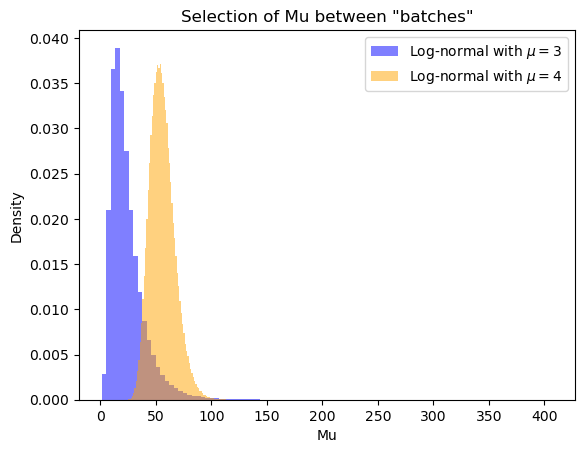

In [3]:
# In this version of the code, I want to create a distribution to "pull" our NB Mu parameters from
# we discussed log-normal
mu_pull_dist_1 = 3
mu_pull_dist_2 = 4


sigma1 = 0.6  # standard deviation of the logarithm of the batch 1 distribution
sigma2 = 0.2  # standard deviation of the logarithm of the batch 2 distribution

# Generate a sample from the log-normal distribution
# Generate samples for both distributions
sample_size = patients_to_generate*100 # multiplication ensures a varied number of possible values
samples1 = np.random.lognormal(mean=mu_pull_dist_1, sigma=sigma1, size=sample_size)
samples2 = np.random.lognormal(mean=mu_pull_dist_2, sigma=sigma2, size=sample_size)

samples1_rounded = np.round(samples1, 6)
samples2_rounded = np.round(samples2, 6)

# Plotting the samples
plt.hist(samples1_rounded, bins=100, density=True, alpha=0.5, color='blue', label=f'Log-normal with $\mu={mu_pull_dist_1}$')
plt.hist(samples2_rounded, bins=100, density=True, alpha=0.5, color='orange', label=f'Log-normal with $\mu={mu_pull_dist_2}$')
plt.title('Selection of Mu between "batches"')
plt.xlabel('Mu')
plt.ylabel('Density')
# plt.xscale('log')
plt.legend()
plt.show()

In [4]:
# for now, theta will be simple, both batch 1 and batch 2 will have the same parameters
# will likely make this more complex in the future
theta_pull_dist_1 = theta_pull_dist_2 = 1 # will try 1, 2, etc


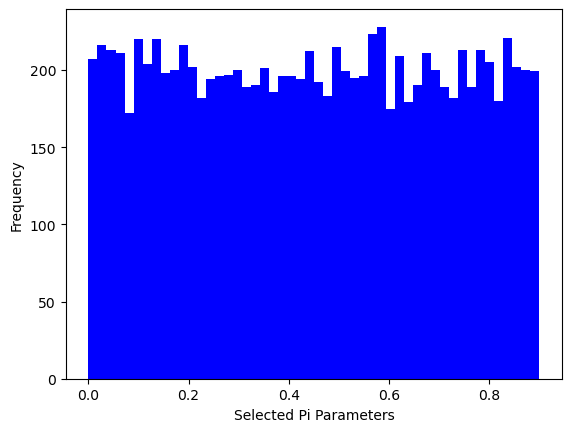

In [5]:
# New - pulling a pi parameter
pi_batch = np.random.uniform(0, 0.9, size=genes_to_generate)

plt.hist(pi_batch, bins=50, color="blue")
plt.xlabel("Selected Pi Parameters")
plt.ylabel("Frequency")
plt.show()

In [6]:
# Container for simulated data
train_data, valid_data, gene_names = [], [], []
gene_mu1, gene_var1, gene_mu2, gene_var2, gene_pi = [], [], [], [], []

# we have to sample from both log normals outside of the loop so that we can ensure replacement
sampled_mus_batch1 = np.random.choice(samples1_rounded, size=genes_to_generate, replace=False)
sampled_mus_batch2 = np.random.choice(samples2_rounded, size=genes_to_generate, replace=False)


# Bernouli trial idea didn't work out
# This way, all samples will get the same mu, not a partial amount
samples_indices = np.random.binomial(n=1, p=batch_balance, size=patients_to_generate)

for i in range(genes_to_generate):
    # so we compute the p and n parameters for each batch using their respective Mu/thetas
    mu_batch1 = sampled_mus_batch1[i]
    var_batch1 = mu_batch1 + (mu_batch1**2 / theta_pull_dist_1)
    n_batch1 = mu_batch1**2 / (var_batch1 - mu_batch1)
    p_batch1 = n_batch1 / (n_batch1 + mu_batch1)

    mu_batch2 = sampled_mus_batch2[i]
    var_batch2 = mu_batch2 + (mu_batch2**2 / theta_pull_dist_2)
    n_batch2 = mu_batch2**2 / (var_batch2 - mu_batch2)
    p_batch2 = n_batch2 / (n_batch2 + mu_batch2)

    zero_inflated_counts_batch1_train = np.zeros(patients_to_generate, dtype=int)
    zero_inflated_counts_batch2_train = np.zeros(patients_to_generate, dtype=int)
    zero_inflated_counts_batch1_val = np.zeros(patients_to_generate, dtype=int)
    zero_inflated_counts_batch2_val = np.zeros(patients_to_generate, dtype=int)

    # old code, this was ~40% slower than below
    #for j in range(patients_to_generate):
        # Check if the count should be zero due to zero inflation
    #    if bernoulli.rvs(pi_batch[i]):
    #        zero_inflated_counts_batch1_train[j], zero_inflated_counts_batch1_val[j] = 0, 0  # Zero due to zero-inflation
    #        zero_inflated_counts_batch2_train[j], zero_inflated_counts_batch2_val[j] = 0, 0
    #    else:
            # Generate from Negative Binomial if not zero-inflated
    #        zero_inflated_counts_batch1_train[j], zero_inflated_counts_batch1_val[j] = nbinom.rvs(n_batch1, p_batch1, size = 2)
    #        zero_inflated_counts_batch2_train[j], zero_inflated_counts_batch2_val[j] = nbinom.rvs(n_batch2, p_batch2, size = 2)

    # I tried to make my work faster but this was actually slower
    counts_batch1_train = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
    counts_batch2_train = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)
    counts_batch1_val = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
    counts_batch2_val = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)

    # separate Bernoulis so training and validation don't have dropout in the same locations
    for j in range(patients_to_generate):
        if bernoulli.rvs(pi_batch[i]):
            # its okay if batches share the dropout as only one of these patients will be chosen for the full dataset
            zero_inflated_counts_batch1_train[j] = 0  # Zero due to zero-inflation for batch1
            zero_inflated_counts_batch2_train[j] = 0  # Zero due to zero-inflation for batch2
        else:
            zero_inflated_counts_batch1_train[j] = counts_batch1_train[j]
            zero_inflated_counts_batch2_train[j] = counts_batch2_train[j]
        
        if bernoulli.rvs(pi_batch[i]):
            zero_inflated_counts_batch1_val[j] = 0  # Zero due to zero-inflation for batch1
            zero_inflated_counts_batch2_val[j] = 0  # Zero due to zero-inflation for batch2
        else:
            zero_inflated_counts_batch1_val[j] = counts_batch1_val[j]
            zero_inflated_counts_batch2_val[j] = counts_batch2_val[j]
        
            

    if (draw_NB_data is True):
        plt.hist(zero_inflated_counts_batch1_train, bins=50, color="blue")
        plt.xlabel("Expression")
        plt.ylabel("Frequency")
        plt.show()

    # and we use the Bernouli to select from which NB distribution do we take values from
    selected_data_train = np.where(samples_indices == 0, zero_inflated_counts_batch1_train, zero_inflated_counts_batch2_train)
    train_data.append(selected_data_train)  

    selected_data_val = np.where(samples_indices == 0, zero_inflated_counts_batch1_val, zero_inflated_counts_batch2_val)
    valid_data.append(selected_data_val)  

    # Saving Mus/Thetas; to be placed in the AnnData 'var' table
    gene_mu1.append(mu_batch1)
    gene_var1.append(theta_pull_dist_1)
    gene_mu2.append(mu_batch2)
    gene_var2.append(theta_pull_dist_2)
    gene_pi.append(pi_batch[i])


    # Creating a unique gene name
    gene_name = "Gene_" + str(i + 1)
    gene_names.append(gene_name)      


In [ ]:
# So now we have to save these results as an AnnData table with batch in the obs
# training data

# append genes into a single matrix, and transpose so rows are samples and not rows
all_counts = np.array(train_data)
counts_in_anndata_orientation = np.transpose(all_counts)

adata = ad.AnnData(X=counts_in_anndata_orientation, var=pd.DataFrame(index=gene_names), dtype=np.int64)

# make batch labels
#batch_labels = ['1'] * size_batch1 + ['2'] * size_batch2  # Adjust according to your data structure
adata.obs['batch'] = samples_indices

# add gene names to var
adata.var['gene'] = gene_names
adata.var['mu_batch1'] = gene_mu1
adata.var['theta_batch1'] = gene_var1
adata.var['mu_batch2'] = gene_mu2
adata.var['theta_batch2'] = gene_var2
adata.var['pi_gene'] = gene_pi

# and lets save the data
file_path = '/path/to/output/simulated_simple_' + str(patients_to_generate) + '_' + str(genes_to_generate) + '_theta_' + str(theta_pull_dist_1) + '_batch_balance_' + str(batch_balance) + '.zinb.test1.tau_1.h5ad'

# Save the AnnData object
adata.write(file_path)


/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
# repeat for validation data
all_counts = np.array(valid_data)
counts_in_anndata_orientation = np.transpose(all_counts)

adata_val = ad.AnnData(X=counts_in_anndata_orientation, var=pd.DataFrame(index=gene_names), dtype=np.int64)

# make batch labels
#batch_labels = ['1'] * size_batch1 + ['2'] * size_batch2  # Adjust according to your data structure
adata_val.obs['batch'] = samples_indices

# add gene names to var
adata_val.var['gene'] = gene_names
adata_val.var['mu_batch1'] = gene_mu1
adata_val.var['theta_batch1'] = gene_var1
adata_val.var['mu_batch2'] = gene_mu2
adata_val.var['theta_batch2'] = gene_var2
adata.var['pi_gene'] = gene_pi

# and lets save the data
file_path = '/path/to/output/simulated_simple_' + str(patients_to_generate) + '_' + str(genes_to_generate) + '_theta_' + str(theta_pull_dist_1) + '_batch_balance_' + str(batch_balance) + '.zinb.extra.tau_1.h5ad'

# Save the AnnData object
adata_val.write(file_path)


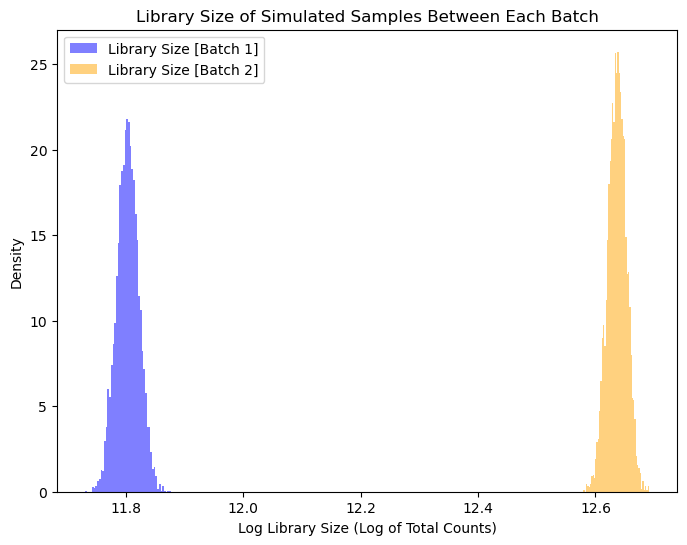

In [10]:
# draw library size information distrubtions
library_sizes = np.log(adata_val.X.sum(axis=1))

batches = adata_val.obs['batch']
library_sizes_batch1 = library_sizes[batches == 0]
library_sizes_batch2 = library_sizes[batches == 1]

# Plotting the samples
#plt.hist(library_sizes, bins=50, density=True, alpha=0.5, color='blue', label=f'Library Size [all samples]')
plt.figure(figsize=(8, 6))
plt.hist(library_sizes_batch1, bins=50, density=True, alpha=0.5, color='blue', label='Library Size [Batch 1]')
plt.hist(library_sizes_batch2, bins=50, density=True, alpha=0.5, color='orange', label='Library Size [Batch 2]')
plt.title('Library Size of Simulated Samples Between Each Batch')
plt.xlabel('Log Library Size (Log of Total Counts)')
plt.ylabel('Density')
# plt.yscale('log')  # Use a log scale for the y-axis
#plt.xscale('log')
plt.legend()
plt.show()

# you can clearly see the difference caused by the two Mus